# Build Your Own AI Agents with LangGraph & Gemini

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/tahreemrasul/langgraph/blob/main/langgraph_gemini_podcast.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/tahreemrasul/langgraph/blob/main/langgraph_gemini_podcast.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>    

| Author |
| --- |
| [Tahreem Rasul](https://github.com/tahreemrasul/) |

# Graphs

## Graph I

In [3]:
!pip install -q langgraph

In [4]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph # framework that helps you design and manage the flow of tasks in your application using a graph structure

In [5]:
# We now create an AgentState - shared data structure that keeps track of information as your application runs.

class AgentState(TypedDict): # Our state schema
    message : str


def greeting_node(state: AgentState) -> AgentState:
    """Simple node that adds a greeting message to the state"""

    state['message'] = "Hey " + state["message"] + ", how is your day going?"

    return state

In [6]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)

graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()

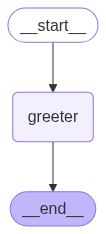

In [7]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
result = app.invoke({"message": "Bob"})

In [9]:
result["message"]

'Hey Bob, how is your day going?'

## Graph II

In [10]:
graph = None
app = None

In [11]:
from typing import TypedDict, List
from langgraph.graph import StateGraph

In [12]:
class AgentState(TypedDict):
    values: List[int]
    name: str
    result: str

In [13]:
def process_values(state: AgentState) -> AgentState:
    """This function handles multiple different inputs"""
    print(state)

    state["result"] = f"Hi there {state['name']}! Your sum = {sum(state['values'])}"

    print(state)
    return state

In [14]:
graph = StateGraph(AgentState)

graph.add_node("processor", process_values)
graph.set_entry_point("processor") # Set the starting node
graph.set_finish_point("processor") # Set the ending node

app = graph.compile() # Compiling the graph

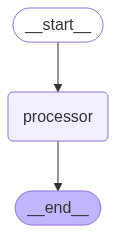

In [15]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
answers = app.invoke({"values": [1,2,3,4], "name": "Steve"})

{'values': [1, 2, 3, 4], 'name': 'Steve'}
{'values': [1, 2, 3, 4], 'name': 'Steve', 'result': 'Hi there Steve! Your sum = 10'}


In [17]:
print(answers["result"])

Hi there Steve! Your sum = 10


## Graph III

In [18]:
graph = None
app = None

In [19]:
from typing import TypedDict # Imports all the data types we need
from langgraph.graph import StateGraph

In [20]:
class AgentState(TypedDict):
    name: str
    age: str
    final: str

In [21]:
def first_node(state:AgentState) -> AgentState:
    """This is the first node of our sequence"""

    state["final"] = f"Hi {state['name']}!"
    return state

def second_node(state:AgentState) -> AgentState:
    """This is the second node of our sequence"""

    state["final"] = state["final"] + f" You are {state['age']} years old!"

    return state

In [22]:
graph = StateGraph(AgentState)

graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)

graph.set_entry_point("first_node")
graph.add_edge("first_node", "second_node")
graph.set_finish_point("second_node")
app = graph.compile()

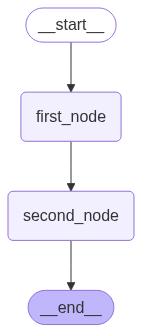

In [23]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
result = app.invoke({"name": "Charlie", "age": 20})
print(result)

{'name': 'Charlie', 'age': 20, 'final': 'Hi Charlie! You are 20 years old!'}


## Graph IV

In [25]:
graph = None
app = None

In [26]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [27]:
class AgentState(TypedDict):
    number1: int
    operation: str
    number2: int
    finalNumber: int

In [28]:
def adder(state:AgentState) -> AgentState:
    """This node adds the 2 numbers"""
    state["finalNumber"] = state["number1"] + state["number2"]

    return state

def subtractor(state:AgentState) -> AgentState:
    """This node subtracts the 2 numbers"""
    state["finalNumber"] = state["number1"] - state["number2"]
    return state


def decide_next_node(state:AgentState) -> AgentState:
    """This node will select the next node of the graph"""

    if state["operation"] == "+":
        return "addition_operation"

    elif state["operation"] == "-":
        return "subtraction_operation"

In [29]:
graph = StateGraph(AgentState)

graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("router", lambda state:state) # passthrough function

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node,

    {
        # Edge: Node
        "addition_operation": "add_node",
        "subtraction_operation": "subtract_node"
    }

)

graph.add_edge("add_node", END)
graph.add_edge("subtract_node", END)

app = graph.compile()

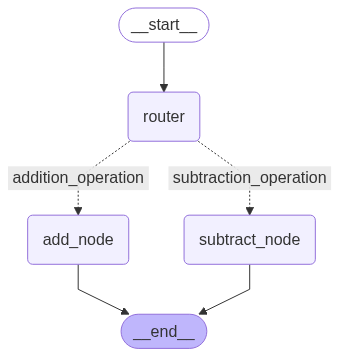

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
initial_state_1 = AgentState(number1 = 10, operation="-", number2 = 5)
print(app.invoke(initial_state_1))

{'number1': 10, 'operation': '-', 'number2': 5, 'finalNumber': 5}


In [32]:
# This way still works!

result = app.invoke({"number1": 10, "operation": "-", "number2": 5})
print(result)

{'number1': 10, 'operation': '-', 'number2': 5, 'finalNumber': 5}


## Graph V

In [33]:
graph = None
app = None

In [34]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

In [35]:
class AgentState(TypedDict):
    name: str
    number: List[int]
    counter: int

In [36]:
def greeting_node(state: AgentState) -> AgentState:
    """Greeting Node which says hi to the person"""
    state["name"] = f"Hi there, {state['name']}"
    state["counter"] = 0

    return state

def random_node(state: AgentState) -> AgentState:
    """Generates a random number from 0 to 10"""
    state["number"].append(random.randint(0, 10))
    state["counter"] += 1

    return state


def should_continue(state: AgentState) -> AgentState:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"  # Continue looping
    else:
        return "exit"  # Exit the loop

In [37]:
# greeting → random → random → random → random → random → END

In [38]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")


graph.add_conditional_edges(
    "random",     # Source node
    should_continue, # Action
    {
        "loop": "random",
        "exit": END
    }
)

graph.set_entry_point("greeting")

app = graph.compile()

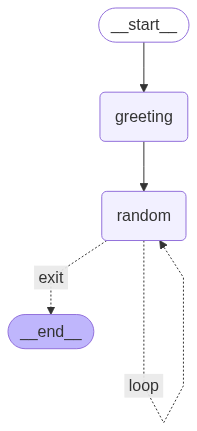

In [39]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
app.invoke({"name":"Vaibhav", "number":[], "counter":-100})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hi there, Vaibhav', 'number': [9, 1, 6, 6, 10], 'counter': 5}

# Setup

## Get started

This section sets up the environment for the ReAct Agent & AI podcast agent. This includes:

- **Installing Libraries:**  Installing the required Python libraries
- **Restarting Runtime (Colab Only):**  Restarting the Colab runtime
- **Authenticating Environment (Colab Only):**  Authenticating to Google Cloud
- **Setting Project Information:**  Setting up your Google Cloud project. This is optional for generating audio.

### Install required packages

This code cell installs the necessary Python libraries for running the AI podcast agent.

In [41]:
%pip install -q -U \
    arxiv \
    google-cloud-aiplatform \
    google-cloud-texttospeech \
    langgraph \
    langchain-google-genai \
    langchain-community \
    pydub \
    pymupdf \
    wikipedia \
    xmltodict

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.4/189.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [42]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Developer API Key

Get API keys from [Google AI Studio](https://aistudio.google.com/), and add it in the cell below.

In [43]:
import os

os.environ["GOOGLE_API_KEY"] = "your_api_key"

# Agent

## ReAct Agent

In [44]:
graph = None
app = None

In [45]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [48]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [49]:
@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

tools = [add, subtract, multiply]

In [50]:
MODEL_ID = "gemini-2.0-flash-001"
model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)
model = model.bind_tools(tools)

In [51]:
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content=
        "You are my AI assistant, please answer my query to the best of your ability."
    )
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}


def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [52]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)


tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

graph.add_edge("tools", "our_agent")

app = graph.compile()

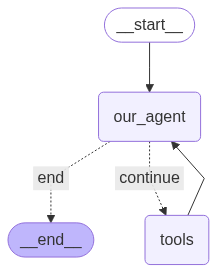

In [53]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [54]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (dde0366f-2595-452b-9a1c-7ac227c93015)
 Call ID: dde0366f-2595-452b-9a1c-7ac227c93015
  Args:
    a: 40.0
    b: 12.0
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  multiply (b1d9d51c-b358-4e4f-82cd-c3897ffc0ded)
 Call ID: b1d9d51c-b358-4e4f-82cd-c3897ffc0ded
  Args:
    a: 52.0
    b: 6.0
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

Okay, 40 + 12 = 52, and 52 * 6 = 312.

Here's a joke for you: Why don't scientists trust atoms? Because they make up everything

# AI-Powered Podcast Creation with Automated Research, Writing, and Refinement

## Overview

Creating a podcast can be a very involved process, requiring extensive research, writing, editing, and production. **What if there was a way to leverage the power of AI to streamline the creation of a podcast, automating many of the tasks traditionally performed by humans?** [NotebookLM](https://notebooklm.google.com/), for example, lets users easily generate [audio overviews based on documents](https://blog.google/technology/ai/notebooklm-audio-overviews/).

#### 🔈🔈 [Listen to a sample podcast generated by this notebook!](https://storage.googleapis.com/github-repo/generative-ai/gemini/orchestration/langgraph/gemini-podcast.mp3) 🔈🔈

But what if you want to customize the length of the podcast, the voices, or the conversation flow and augment it with additional research tools? In this notebook, **you'll recreate this kind of podcast generation functionality by building an AI agent to do the heavy lifting and then customize the entire flow yourself!**

**This notebook demonstrates how to build a [LangGraph](https://langchain-ai.github.io/langgraph/)-powered AI agent to research, write, and refine a podcast script using the [Gemini Developer API](https://aistudio.google.com/) and [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models)** for audio generation. You'll use LangGraph and LangChain to orchestrate calls to Gemini along with calls to different search tools, allowing the AI to learn about a given topic before writing about it. Then, the AI will critique its work and iterate on the podcast script, improving it with each revision.

Here's how you'll build and use our AI podcasting agent:

- **[User]** Define the podcast topic: Provide a clear and concise topic for the podcast.
- **[Agent]** Generate an outline: Use Gemini to create a high-level outline, structuring the podcast's flow.
- **[Agent]** Conduct research: The AI agent will use search tools like arXiv, PubMed, and Wikipedia to gather relevant information.
- **[Agent]** Write a script: Gemini will generate an engaging podcast script, incorporating the research findings.
- **[Agent]** Critique and iterate: The agent will analyze its script, provide a critique, then generate a revised draft.
- **[Optional Agent]** Generate audio: You'll use text-to-speech to generate audio for each line of the podcast script.

<img src="https://storage.googleapis.com/github-repo/generative-ai/gemini/orchestration/langgraph/gemini-podcast-agent.jpg" width="400px">

## Building the AI podcasting agent

This section constructs the AI agent. Key steps include:

- **Initializing Agent Memory and State:** Setting up the agent's memory and defining its data structure
- **Initializing the Gemini Model:**  Loading the Gemini language model from Vertex AI
- **Defining Search Tools:**  Creating tools to access information sources like arXiv, PubMed, and Wikipedia
- **Defining Workflow Stages:** Defining each stage of the workflow, including prompts and functions
- **Compiling the Workflow:**  Structuring the workflow as a graph using LangGraph

### Import libraries

This section imports the necessary libraries for LangGraph, LangChain, Vertex AI, and other utilities needed for your agent's functionality.

This includes tools for interacting with the Gemini API, defining custom tools, managing agent state, and displaying results.

In [55]:
# Common libraries
import logging
import os
import re

# Typing utilities for data validation and schema definitions
from typing import TypedDict

from IPython.display import Audio, Image, display, Markdown

# Libraries for text-to-speech generation and audio processing
from google.cloud import texttospeech
from langchain.schema.document import Document
from langchain_google_genai import ChatGoogleGenerativeAI

# Tools
from langchain_community.retrievers import (
    ArxivRetriever,
    PubMedRetriever,
    WikipediaRetriever,
)

# LangChain and LangGraph components for message handling and tool integration
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool

# LangChain integrations for Gemini API in Google AI Studio
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode
from pydub import AudioSegment

# Set logging level to ERROR to filter warnings
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

### Initialize agent memory and agent state

Here, you initialize your [agent's memory](https://langchain-ai.github.io/langgraph/how-tos/memory/manage-conversation-history/) to store information during the workflow.

You also define the schema for your [agent's state](https://langchain-ai.github.io/langgraph/how-tos/state-model/), which includes the podcast outline, search queries, and drafts.

In [56]:
# Initialize agent memory
memory = MemorySaver()


# Define the agent's state
class AgentState(TypedDict):
    revision_number: int
    max_revisions: int
    search_count: int
    max_searches: int
    task: str
    outline: str
    queries: list
    content: list
    draft: str
    critique: str
    tool_calls: list

### Initialize Gemini model

Initialize the Gemini model from Vertex AI, specifying the model version and temperature settings.

This sets up the core language model that will power your agent's actions.

In [57]:
MODEL_ID = "gemini-2.0-flash-001"

In [58]:
model = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0)

### Define search tools

This section defines custom tools that will be used by your AI podcast agent to gather information from various sources. These tools act as interfaces to external services and provide access to relevant data for the podcast topic.

Each tool is implemented as a Python function decorated with the `@tool` decorator from LangChain. This decorator makes it easy to integrate these functions into LangGraph workflows.

The following search tools are defined:

- **`search_arxiv`:** Retrieves research papers from arXiv based on a keyword query.
- **`search_pubmed`:** Searches for information on PubMed, a database of biomedical literature.
- **`search_wikipedia`:** Fetches information from Wikipedia based on a keyword query.

Your LangGraph application will use these tool nodes to call the corresponding search functions and obtain information from these external sources. This allows the AI agent to learn about the podcast topic before generating the script.

In [59]:
@tool
def search_arxiv(query: str) -> list[Document]:
    """Search for relevant publications on arXiv"""
    retriever = ArxivRetriever(
        load_max_docs=2,
        get_full_documents=True,
    )
    docs = retriever.invoke(query)
    if docs:
        return docs
    else:
        return ["No results found on arXiv"]


@tool
def search_pubmed(query: str) -> list[Document]:
    """Search for information on PubMed"""
    retriever = PubMedRetriever()
    docs = retriever.invoke(query)
    if docs:
        return docs
    else:
        return ["No results found on PubMed"]


@tool
def search_wikipedia(query: str) -> list[Document]:
    """Search for information on Wikipedia"""
    retriever = WikipediaRetriever()
    docs = retriever.invoke(query)
    if docs:
        return docs
    else:
        return ["No results found on Wikipedia"]

### Define workflow stages along with corresponding prompts and functions

This section defines the different stages of the AI podcast agent's workflow and the corresponding prompt templates and node functions that drive each stage.

Each stage represents a specific task in the podcast creation process, such as generating an outline, conducting research, writing the script, and providing a critique.

For each stage, you'll define:

- **Prompt Template:** A carefully crafted text prompt that instructs the Gemini language model on what to do at that stage. The prompt provides context, instructions, and any necessary input data.
- **Node Function:** A Python function that encapsulates the logic for executing that stage. The function typically involves:
    - Constructing the prompt with relevant information from the agent's state.
    - Invoking the Gemini API with the prompt.
    - Processing the model's response and updating the agent's state.

These prompt templates and node functions are the building blocks of the LangGraph workflow that orchestrates the entire podcast creation process.

#### Podcast outline node

This node generates a structured outline for the podcast based on the user-provided topic:

In [60]:
OUTLINE_PROMPT = """You are an expert writer tasked with writing a high level outline of an engaging 2-minute podcast.
Write such an outline for the user provided topic. Give an outline of the podcast along with any
relevant notes or instructions for the sections."""


# Generate an outline for the podcast based on the user-provided topic
def podcast_outline_node(state: AgentState):
    messages = [
        SystemMessage(content=OUTLINE_PROMPT),
        HumanMessage(content=state["task"]),
    ]
    response = model.invoke(messages)
    return {"outline": response.content}

#### Research plan node

This node formulates a search query based on the podcast topic and previous queries:

In [61]:
RESEARCH_PLAN_PROMPT = """You are a researcher tasked with providing information that can
be used when writing the following podcast. Generate one search query consisting of a few
keywords that will be used to gather any relevant information. Do not output any information
other than the query consisting of a few words.

These were the past queries, do not repeat keywords from past queries in your newly generated query:
---
{queries}"""


# Generates a search query based on the outline
def research_plan_node(state: AgentState):
    messages = [
        SystemMessage(content=RESEARCH_PLAN_PROMPT.format(queries=state["queries"])),
        HumanMessage(content=state["task"]),
    ]
    response = model.invoke(messages)
    queries = state["queries"]
    if queries:
        queries.append(response.content)
    else:
        queries = [response.content]
    return {"queries": queries}

#### Research task node

This node executes a search using the selected tool and query, retrieving relevant information for the podcast:

In [62]:
RESEARCH_TASK_PROMPT = """Use the available search tools and search queries to find information
relevant to the podcast. Try searching different sources to obtain different articles. Try using
different search tools than what was used previously so that you can obtain a broader range of
information.

These are the previous tool calls, so you can choose a different tool:
---
{tool_calls}
---
These are the previous search results, so you can aim for different sources and content:
---
{content}"""


# Performs searches using tools
def research_agent_node(state: AgentState):
    tool_calls = state["tool_calls"]
    content = state["content"]
    queries = state["queries"]
    query = queries[-1]
    messages = [
        SystemMessage(
            content=RESEARCH_TASK_PROMPT.format(tool_calls=tool_calls, content=content)
        ),
        HumanMessage(content=query),
    ]

    # Perform function calls
    tools = [search_arxiv, search_pubmed, search_wikipedia]
    model_with_tools = model.bind_tools(tools)
    response_tool_calls = model_with_tools.invoke(messages)
    if tool_calls:
        tool_calls.append(response_tool_calls)
    else:
        tool_calls = [response_tool_calls]

    # Defines a tool node based on search functions
    tool_node = ToolNode(tools)
    response = tool_node.invoke({"messages": [response_tool_calls]})

    # Add the search results to the content list in the agent state
    for message in response.get("messages", []):
        if isinstance(message, ToolMessage):
            content.insert(0, message.content)

    return {
        "content": content,
        "tool_calls": tool_calls,
        "search_count": state["search_count"] + 1,
    }


# Determine whether to continue research based on the number of searches performed
def should_continue_tools(state: AgentState):
    if state["search_count"] > state["max_searches"]:
        return "generate_script"
    else:
        return "research_plan"

#### Podcast writing node

This node generates a draft podcast script using the outline and research results, aiming for an engaging and informative style:

In [63]:
WRITER_PROMPT = """
You are a writing assistant tasked with writing engaging 2-minute podcast scripts.

- Generate the best podcast script possible for the user's request and the initial outline.
- The script MUST strictly alternate lines between the two hosts, separating each host's line with a newline.
- Add an intro phrase and outro phrase to start and end the podcast, and use a fun, random name for the podcast show.
- Given a critique, respond with a revised version of your previous script.
- Include lively back-and-forth chatter, reflections, and expressions of amazement between the hosts.
- Cite at least THREE pieces of research throughout the script, choosing the most relevant research for each point.
- DO NOT include ANY of the following:
    - Speaker labels (e.g., "Host 1:", "Host 2:")
    - Sound effect descriptions (e.g., "[Sound of waves]")
    - Formatting instructions (e.g., "(Emphasis)", "[Music fades in]")
    - Any other non-dialogue text.
- Use this format for citations, including the month and year if available:
    "In [Month, Year], [Organization] found that..."
    "Research from [Organization] in [Month, Year] showed that..."
    "Back in [Month, Year], a study by [Organization] suggested that..."
---
Utilize all of the following search results and context as needed:
{content}
---
If this is a revision, the critique will be provided below:
{critique}"""


# Generates a draft of the script based on the content and outline
def generate_script_node(state: AgentState):
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(
                content=state["content"], critique=state.get("critique", "")
            )
        ),
        HumanMessage(
            content=f"{state['task']}\n\nHere is my outline:\n\n{state['outline']}"
        ),
    ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "search_count": 0,  # Reset the search count for the next revision
        "revision_number": state.get("revision_number", 1) + 1,
    }

#### Podcast critique node

This node provides feedback and suggestions for improvement on the generated podcast script:

In [64]:
CRITIQUE_PROMPT = """You are a producer grading a podcast script.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for conciseness, depth, style, etc."""


# Generates a critique with feedback on the draft podcast script
def perform_critique_node(state: AgentState):
    messages = [
        SystemMessage(content=CRITIQUE_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

#### Research critique node

This node generates a new search query based on the critique of the script, aiming to address weaknesses and find additional information:

In [65]:
RESEARCH_CRITIQUE_PROMPT = """You are a writing assistant tasked with providing information that can
be used when making any requested revisions (as outlined below).
Generate one search query consisting of a few keywords that will be used to gather any relevant
information. Do not output any information other than the query consisting of a few words.

---

These were the past queries, so you can vary the query that you generate:

{queries}
"""


# Generates a new search query based on the critique
def research_critique_node(state: AgentState):
    messages = [
        SystemMessage(
            content=RESEARCH_CRITIQUE_PROMPT.format(queries=state["queries"])
        ),
        HumanMessage(content=state["critique"]),
    ]
    response = model.invoke(messages)
    queries = state.get("queries", [])
    if queries:
        queries.append(response.content)
    else:
        queries = [response.content]
    return {"queries": queries}


# Decide whether to continue to the next revision or end the process
def should_continue(state: AgentState):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "perform_critique"

## Define and compile the LangGraph workflow

This section defines the structure and flow of the AI podcast agent using LangGraph.

The workflow is constructed as a graph with nodes representing each stage in the process (e.g., outlining, research, script generation) and edges defining the transitions between these stages.

The workflow includes two main loops:

- **Research Loop:**  This loop iteratively plans and executes searches until a specified number of searches are completed.
- **Critique and Revision Loop:** This loop handles the script critique, additional research based on the critique, and script revision, repeating for a set number of revisions.

The `workflow.compile()` function transforms this graph definition into an executable workflow, incorporating memory management to maintain the agent's state throughout the process.

In [66]:
# Initialize the state graph
workflow = StateGraph(AgentState)

# Define the nodes of the workflow, representing each stage of the process
workflow.add_node("podcast_outline", podcast_outline_node)
workflow.add_node("research_plan", research_plan_node)
workflow.add_node("research_agent", research_agent_node)
workflow.add_node("generate_script", generate_script_node)
workflow.add_node("perform_critique", perform_critique_node)
workflow.add_node("research_critique", research_critique_node)

# Specify the starting node of the workflow
workflow.set_entry_point("podcast_outline")

# Define the flow between node and stages
workflow.add_edge("podcast_outline", "research_plan")
workflow.add_edge("research_plan", "research_agent")
workflow.add_edge("perform_critique", "research_critique")
workflow.add_edge("research_critique", "research_agent")

# Define conditional edges for the research loop
workflow.add_conditional_edges(
    "research_agent",
    should_continue_tools,
    {"generate_script": "generate_script", "research_plan": "research_plan"},
)

# Define conditional edges for the critique and revision loop
workflow.add_conditional_edges(
    "generate_script",
    should_continue,
    {END: END, "perform_critique": "perform_critique"},
)

# Compile the workflow graph, enabling memory to track agent state
graph = workflow.compile(checkpointer=memory)

### Visualize the workflow

This cell visualizes the compiled LangGraph workflow as a [Mermaid diagram](https://mermaid.js.org/).

The diagram provides a clear and intuitive representation of the workflow's structure, showing the nodes, edges, and the flow of execution.

This visualization helps to understand the overall process and the interactions between different stages of the AI podcast agent.

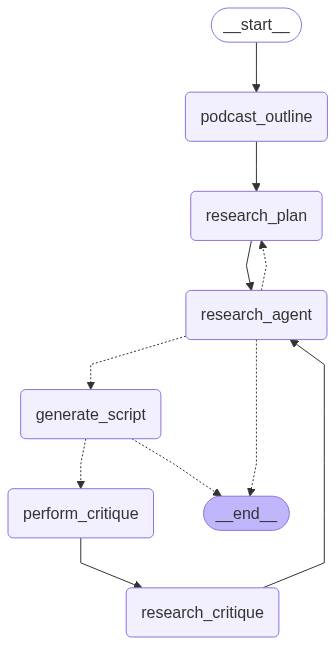

In [67]:
# Display a Mermaid diagram of the workflow
Image(graph.get_graph().draw_mermaid_png())

### Define the podcast topic

This cell defines the topic of the podcast that the AI agent will create.

The topic is assigned to the variable `PODCAST_TOPIC`. Feel free to modify this variable to explore different podcast topics!

In [68]:
PODCAST_TOPIC = "Explain the design of generative AI apps for enterprises and which design principles should be used"

### Run the AI podcast agent

This cell executes the compiled LangGraph workflow, running the AI podcast agent to generate the podcast script.

The code performs these actions:

- **Clean agent helper function:**  This function prepares the agent's output for printing by removing unnecessary characters and formatting
- **Thread Configuration:**  A thread configuration is defined to ensure a unique history for this workflow execution
- **Workflow Execution:** The `graph.stream()` method runs the workflow, iterating through each stage and updating the agent's state
- **Output Display:** The code prints the results of each stage, including the agent's actions and generated output

In [71]:
# Function to clean and format agent output for display
def clean_agent_result(data):
    agent_result = str(data)
    agent_result = re.sub(
        r"[^\x00-\x7F]+", " ", agent_result
    )  # Remove non-ASCII characters
    agent_result = re.sub(r"\\\\n", "\n", agent_result)  # Replace escaped newlines
    agent_result = re.sub(r"\\n", "", agent_result)  # Replace newlines
    agent_result = re.sub(r"\\'", "'", agent_result)  # Replace escaped single quotes
    return agent_result


# Thread ID for unique history in workflow execution
thread = {"configurable": {"thread_id": "1"}}

# Run the LangGraph workflow, passing the initial state and thread configuration
for state in graph.stream(
    {
        "task": PODCAST_TOPIC,
        "revision_number": 1,  # Current revision number
        "max_revisions": 2,  # Maximum number of revisions allowed
        "search_count": 0,  # Current search number
        "max_searches": 1,  # Maximum number of searches allowed per revision
        "content": [],
        "queries": [],
        "tool_calls": [],
    },
    thread,
):
    # Print a snippet of the results of each workflow stage
    for k, v in state.items():
        print(f"Agent Node: {k}\n")
        print("Agent Result:")
        display(Markdown(clean_agent_result(v)[:1000]))
    print("\n====================\n")

Agent Node: podcast_outline

Agent Result:


{'outline': 'Okay, here's a podcast outline for a 2-minute episode explaining the design of generative AI apps for enterprises, focusing on key design principles.**Podcast Title:** Designing Generative AI for the Enterprise: Key Principles in 2 Minutes**Target Audience:** Business leaders, product managers, IT professionals, and anyone interested in understanding how to build useful and responsible generative AI applications within a corporate setting.**Overall Tone:**  Informative, practical, and slightly enthusiastic about the potential of generative AI, but grounded in real-world considerations.---**Podcast Outline:****(0:00 - 0:10) Introduction - Hook & Context (10 seconds)***   **Content:**    *   Start with a compelling question or statement: "Want to unlock the power of generative AI for your business, but not sure where to start? It's all about design."    *   Briefly define generative AI in the enterprise context (e.g., "Generative AI apps can automate tasks, create content, a



Agent Node: research_plan

Agent Result:


{'queries': ['generative AI enterprise application design']}



Agent Node: research_agent

Agent Result:


{'content': ['[Document(metadata={'title': 'Generative artificial intelligence', 'summary': 'Generative artificial intelligence (Generative AI, GenAI, or GAI) is a subfield of artificial intelligence that uses generative models to produce text, images, videos, or other forms of data. These models learn the underlying patterns and structures of their training data and use them to produce new data based on the input, which often comes in the form of natural language prompts.
Generative AI tools have become more common since an "AI boom" in the 2020s. This boom was made possible by improvements in transformer-based deep neural networks, particularly large language models (LLMs). Major tools include chatbots such as ChatGPT, DeepSeek, Copilot, Gemini, Llama, and Grok; text-to-image artificial intelligence image generation systems such as Stable Diffusion, Midjourney, and DALL-E; and text-to-video AI generators such as Sora. Technology companies developing generative AI include OpenAI, Anth



Agent Node: research_plan

Agent Result:


{'queries': ['generative AI enterprise application design', 'generative AI application architecture']}



Agent Node: research_agent

Agent Result:


{'content': ['[Document(metadata={'title': 'Generative artificial intelligence', 'summary': 'Generative artificial intelligence (Generative AI, GenAI, or GAI) is a subfield of artificial intelligence that uses generative models to produce text, images, videos, or other forms of data. These models learn the underlying patterns and structures of their training data and use them to produce new data based on the input, which often comes in the form of natural language prompts.
Generative AI tools have become more common since an "AI boom" in the 2020s. This boom was made possible by improvements in transformer-based deep neural networks, particularly large language models (LLMs). Major tools include chatbots such as ChatGPT, DeepSeek, Copilot, Gemini, Llama, and Grok; text-to-image artificial intelligence image generation systems such as Stable Diffusion, Midjourney, and DALL-E; and text-to-video AI generators such as Sora. Technology companies developing generative AI include OpenAI, Anth



Agent Node: generate_script

Agent Result:


{'draft': 'Alright, buckle up for "The Algorithmic Albatross"!Want to unlock the power of generative AI for your business, but not sure where to start? It's all about design!Generative AI apps can automate tasks, create content, and personalize experiences, but only if designed right. In the next two minutes, we'll cover the core design principles for building effective and responsible generative AI applications for your enterprise.First, define clear business goals and use cases. Don't just build AI for the sake of it. Identify a real pain point.Think automating customer support responses, generating marketing copy, or summarizing lengthy documents. How will you measure success? Increased efficiency? Improved customer satisfaction? Define your KPIs upfront!Exactly! Now, let's talk data. Generative AI is only as good as the data it's trained on. Garbage in, garbage out!That's right! We need high-quality, relevant, and unbiased data. And, of course, we need to protect sensitive data. Im



Agent Node: perform_critique

Agent Result:


{'critique': 'Okay, here's a breakdown of your "The Algorithmic Albatross" podcast script, focusing on areas for improvement and specific recommendations:**Overall Impression:**The script has a good foundation. It's concise, touches on important points, and aims to be actionable. However, it needs tightening, a clearer structure, and a more engaging style to truly capture and retain listener attention. The references feel a bit shoe-horned in.**Specific Feedback and Recommendations:**1.  **Title:**    *   "The Algorithmic Albatross" is intriguing, but potentially off-putting. An albatross is a burden. Is that the message you want to send? Consider something more positive and descriptive.    *   **Recommendation:** Brainstorm alternative titles that highlight the benefits of well-designed generative AI. Examples: "AI Advantage," "Generative AI Blueprint," "Designing AI Success."2.  **Opening (First 15-20 seconds):**    *   The current opening is okay, but it can be more compelling. You 



Agent Node: research_critique

Agent Result:


{'queries': ['generative AI enterprise application design', 'generative AI application architecture', 'generative AI podcast design principles']}



Agent Node: research_agent

Agent Result:


{'content': ["Error: ConnectionError(ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))) Please fix your mistakes.", '["No results found on PubMed"]', '[Document(metadata={'title': 'Generative artificial intelligence', 'summary': 'Generative artificial intelligence (Generative AI, GenAI, or GAI) is a subfield of artificial intelligence that uses generative models to produce text, images, videos, or other forms of data. These models learn the underlying patterns and structures of their training data and use them to produce new data based on the input, which often comes in the form of natural language prompts.
Generative AI tools have become more common since an "AI boom" in the 2020s. This boom was made possible by improvements in transformer-based deep neural networks, particularly large language models (LLMs). Major tools include chatbots such as ChatGPT, DeepSeek, Copilot, Gemini, Llama, and Grok; text-to-image artificial intelligence image ge



Agent Node: research_plan

Agent Result:


{'queries': ['generative AI enterprise application design', 'generative AI application architecture', 'generative AI podcast design principles', 'generative AI app development lifecycle']}



Agent Node: research_agent

Agent Result:


{'content': ['[Document(metadata={'title': 'Dynatrace', 'summary': 'Dynatrace, Inc. is an American multinational technology company that provides an observability platform. Their software is used to monitor, analyze, and optimize application performance, software development, cyber security practices, IT infrastructure, and user experience.
Dynatrace uses a proprietary form of artificial intelligence called Davis to discover, map, and monitor applications, microservices, container orchestration platforms such as Kubernetes, and IT infrastructure running in multicloud, hybrid-cloud, and hyperscale network environments. The platform also provides automated problem remediation and IT carbon impact analysis. The platform provides observability across the solution stack  to manage the complexities of cloud native computing, and support digital transformation and cloud migration.', 'source': 'https://en.wikipedia.org/wiki/Dynatrace'}, page_content="Dynatrace, Inc. is an American multinationa



Agent Node: generate_script

Agent Result:


{'draft': 'Alright, buckle up for "Bytesized Bananas," your go-to podcast for all things AI!Want to unlock the power of generative AI for your business, but not sure where to start? It's all about design.Generative AI apps can automate tasks, create content, and personalize experiences, but only if designed right. In the next two minutes, we'll cover the core design principles for building effective and responsible generative AI applications for your enterprise.Don't just build AI for the sake of it. Identify a real pain point. Think automating customer support responses, generating marketing copy, or summarizing lengthy documents.Exactly! And how will you measure success? Increased efficiency? Improved customer satisfaction? Define your KPIs upfront. According to McKinsey, defining clear objectives is the first step to AI success.Generative AI is only as good as the data it's trained on. Garbage in, garbage out.Absolutely. You need high-quality, relevant, and unbiased data. Plus, prot

### Parse and display the final podcast script

This section extracts and prepares the final podcast script generated by the AI agent.

It displays the script for review, where each string in the list will be narrated by a different text-to-speech voice.

In [72]:
podcast_script = state["generate_script"]["draft"]
parsed_script = [
    text for text in (line.strip() for line in podcast_script.splitlines()) if text
]
parsed_script

['Alright, buckle up for "Bytesized Bananas," your go-to podcast for all things AI!',
 "Want to unlock the power of generative AI for your business, but not sure where to start? It's all about design.",
 "Generative AI apps can automate tasks, create content, and personalize experiences, but only if designed right. In the next two minutes, we'll cover the core design principles for building effective and responsible generative AI applications for your enterprise.",
 "Don't just build AI for the sake of it. Identify a real pain point. Think automating customer support responses, generating marketing copy, or summarizing lengthy documents.",
 'Exactly! And how will you measure success? Increased efficiency? Improved customer satisfaction? Define your KPIs upfront. According to McKinsey, defining clear objectives is the first step to AI success.',
 "Generative AI is only as good as the data it's trained on. Garbage in, garbage out.",
 "Absolutely. You need high-quality, relevant, and unbi

### Generate audio for the podcast [Optional]

This cell generates audio for each line of the parsed podcast script using Google Cloud's Text-to-Speech API.

It creates separate audio files for each line, alternating between two different voices to simulate a conversation between two podcast hosts.

The code:

1. **Initializes the Text-to-Speech Client:**  Sets up the connection to the API.
2. **Defines Audio Configuration:** Specifies the desired output audio format (MP3).
3. **Iterates through Script Lines:** Generates audio for each line, alternating voices.
4. **Saves Audio Files:**  Writes the generated audio to separate MP3 files.

For generating the audio, we need the texttospeech model that's hosted inside Google Cloud. For this, you would want to create a project inside GCP, and add the project ID below.


1.   To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).
2.   Additionally, enable the [Google Cloud Text-to-Speech API](https://console.cloud.google.com/apis/library/texttospeech.googleapis.com?inv=1&invt=AbyIow) in the created project.

In [73]:
import os

import vertexai

PROJECT_ID = "your_project_ID"  # @param {type:"string", isTemplate: true}
if PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

vertexai.init(project=PROJECT_ID, location=LOCATION)

You also need the service account credentials for the project you have created.
1. Go to https://console.cloud.google.com/iam-admin/serviceaccounts
2. Create a service account for the project you created above.
3. Download its JSON key, and add it to the `sample_data` folder. Add the path in the cell below.

In [74]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/gcp-project-service-account.json"

In [77]:
# Instantiates a client
client = texttospeech.TextToSpeechClient()

# Select the type of audio file you want returned
audio_config = texttospeech.AudioConfig(audio_encoding=texttospeech.AudioEncoding.MP3)

audio_files = []
for count, line in enumerate(parsed_script):
    # Set the text input to be synthesized
    synthesis_input = texttospeech.SynthesisInput(text=line)

    # Choose the voice for the current line, alternating between hosts
    if count % 2 == 0:
        voice_name = "en-US-Chirp3-HD-Aoede"
    elif count % 2 == 1:
        voice_name = "en-US-Chirp3-HD-Puck"

    # Configure voice parameters: language and voice name
    voice = texttospeech.VoiceSelectionParams(
        language_code="en-US",
        name=voice_name,
    )

    # Generate audio using the Text-to-Speech API
    response = client.synthesize_speech(
        input=synthesis_input, voice=voice, audio_config=audio_config
    )

    # Save the generated audio to an MP3 file
    filename = f"part-{str(count)}.mp3"
    audio_files.append(filename)
    with open(filename, "wb") as out:
        out.write(response.audio_content)
        print(f"Audio content written to file {filename}")

Audio content written to file part-0.mp3
Audio content written to file part-1.mp3
Audio content written to file part-2.mp3
Audio content written to file part-3.mp3
Audio content written to file part-4.mp3
Audio content written to file part-5.mp3
Audio content written to file part-6.mp3
Audio content written to file part-7.mp3
Audio content written to file part-8.mp3
Audio content written to file part-9.mp3
Audio content written to file part-10.mp3
Audio content written to file part-11.mp3
Audio content written to file part-12.mp3
Audio content written to file part-13.mp3


### Combine audio files and generate final podcast

This cell combines the individual audio files generated in the previous step into a single podcast file.

It also adds brief silences between each line for better listening experience.

The final podcast is saved as `gemini-podcast.mp3`.

In [78]:
# Initialize audio segment
full_audio = AudioSegment.silent(duration=200)

# Concatenate audio segments with silence in between
for file in audio_files:
    sound = AudioSegment.from_mp3(file)
    silence = AudioSegment.silent(duration=200)
    full_audio += sound + silence
    os.remove(file)  # Remove the individual part files after combining

# Save the final audio output to a file
podcast_filename = "gemini-podcast.mp3"
full_audio.export(podcast_filename)
print(f"Podcast content written to file {podcast_filename}")

Podcast content written to file gemini-podcast.mp3


### Listen to your AI-generated podcast!

This cell plays the final podcast generated by the AI agent.

The `Audio` object from `IPython.display` is used to embed the audio player directly into the notebook. The podcast will start playing automatically.

Enjoy your AI-created podcast!

In [79]:
Audio(filename=podcast_filename, rate=32000, autoplay=True)

## Conclusion: Building AI-powered podcast agents

This notebook showcases the exciting potential of using AI to automate the podcast creation process. By combining the power of the Gemini API with the flexibility of LangGraph, you built an intelligent agent capable of:

- **Generating Podcast Outlines:** Structuring the flow and content of the podcast.
- **Conducting Research:**  Gathering information from various sources like arXiv, PubMed, and Wikipedia.
- **Writing Engaging Scripts:** Crafting podcast scripts with natural-sounding dialogue, citations, and a conversational style.
- **Critiquing and Revising:** Providing feedback on the script and iteratively refining it.
- **Generating Audio:**  Using text-to-speech technology to create the final podcast audio.

This is just a starting point! You can customize this workflow further by:

- **Adding New Research Tools:**  Integrate additional sources of information relevant to your podcast topics.
- **Experimenting with Prompts:** Refine the prompts to guide the AI agent towards your desired style and content.
- **Exploring Different Voices:**  Use a wider range of voices for the podcast hosts to create unique and engaging listening experiences.

The possibilities are endless! As AI technology continues to advance, you can expect even more creative and innovative applications in podcasting and other content creation domains.

You can learn more about [LangGraph](https://langchain-ai.github.io/langgraph/), the [Gemini API in Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models), or the [chat model provider for Vertex AI in LangChain](https://python.langchain.com/docs/integrations/chat/google_vertex_ai_palm/) in their respective documentation pages.